<a href="https://colab.research.google.com/github/Gastfigue/coderhouse/blob/main/Desafio_FeatureSelection_Rodriguez_Figueredo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data acquisition / Data Wranling

**Analizar datos Tabulares**

- importamos liberias

In [ ]:
import pandas as pd #manipulacion de dataframe
import numpy as np #manipular arreglos (array)
import matplotlib.pyplot as plt #visualizaciones
import re # reemplazar espacios de las variables del dataset
import seaborn as sns #visualizaciones
import statsmodels.api as sm 
from sklearn import metrics # modulo para evaluar metricas del modelo
from sklearn.ensemble import RandomForestClassifier #Algoritmo para clasificacion
from sklearn.model_selection import train_test_split #separar datos para test y train
from sklearn.preprocessing import LabelEncoder # nos permite convertir las variables categorias a numeros, (Gender M/F a 0/1)
from sklearn import metrics
from sklearn.model_selection import cross_val_score

- Importamos el dataset directamente de Kaggle  (Es necesario tener en nuestra carpeta el token kaggle.json)

In [ ]:
!ls -lha kaggle.json
!pip install -q kaggle # installing the kaggle package
!mkdir -p ~/.kaggle # creating .kaggle folder where the key should be placed
!cp kaggle.json ~/.kaggle/ # move the key to the folder
!pwd # checking the present working directory
!kaggle datasets download -d teejmahal20/airline-passenger-satisfaction #ir a Kaggle y presionar en (...) luego Copy API command
!unzip /content/airline-passenger-satisfaction.zip #descomprimir archivo
df=pd.read_csv('train.csv') #Generamos el dataframe a partir del csv


-rw-r--r-- 1 root root 70 Mar 24 14:53 kaggle.json
/content
airline-passenger-satisfaction.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  /content/airline-passenger-satisfaction.zip
  inflating: test.csv                
  inflating: train.csv               


**Data Wrangling**

1.   Detección de valores nulos
2.   Detección de valores duplicados
3.   Manejo de datos faltantes



- Deteccion de valores nulos

In [ ]:
pd.set_option("display.max_rows",None)
df_nulos=df.isnull().sum().sort_values(ascending=False)
df_nulos[df_nulos>0] 

Arrival Delay in Minutes    310
dtype: int64

- Detección de valores duplicados

In [ ]:
df_dup=(df.duplicated() == True).sum()
df_dup

0

- Manejo de datos faltantes

Comenzamos eliminando las columnas que no son utiles para el analisis en cuestion, y convertimos las propiedades de los datos desde integer a variables categoricas. De los 310 datos nulos antes presentados de la variable " Arrival Delay in Minutes" se reemplazaran por su media correspondiente, siendo la misma de 15.1786.

Dado que no existen valores duplicados no se aplican cambios y se modifican los espacios en blanco de las variables por el caracter "_", concluyendo asi el manejo de datos faltantes para comenzar el analisis descriptivo.

In [ ]:
df=df.drop(['Unnamed: 0','id'],axis=1) # Eliminar col Unnamed y id
l=[x for x in df.columns if x  in ['Gender','Customer Type','Type of Travel', 'Class', 'satisfaction']]
df[l]=df[l].astype('category') #Convertir variables tipo int a category
avg_norm_loss = df['Arrival Delay in Minutes'].astype("float").mean(axis=0) #Imputacion de datos nulos ***
df['Arrival Delay in Minutes'].replace(np.nan, avg_norm_loss, inplace=True)

#Cambiamos los espacios de las variables del dataset por "_"
for i in df.columns: 
  a=re.sub(r"\s+","_",i)
  df.rename(columns={i:a},inplace=True) 


# Ingenieria de atributos y selecion de variables

## Tratamos datos antes de aplicar modelo

In [ ]:
#Separamos variable target - variable independientes
X=df.drop(['satisfaction'],axis=1)
y=df['satisfaction']
#Se aplica metodo get_dummies() a variables numericas
X=pd.get_dummies(X, columns=['Gender','Customer_Type','Type_of_Travel','Class'])
#Se aplica label_enconder a la variable target
le=LabelEncoder()
y=le.fit_transform(df['satisfaction'])
#Aplicamos Scaler
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
X=scaler.fit_transform(X)
X=pd.DataFrame(X)
#Variables independientes
#X.head()
#Variable Target
#y

## Aplicamos modelo sin PCA

In [ ]:
#Separamos entre train y test
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=12)
#Aplicamos modelo
rf= RandomForestClassifier(random_state=12)
rf.fit(X_train, y_train)
y_pred=rf.predict(X_test)

**Metricas**

In [ ]:
acurracy=metrics.accuracy_score(y_test,y_pred)
precision=metrics.precision_score(y_test,y_pred)
sensibilidad=metrics.recall_score(y_test,y_pred)
f1_score=metrics.f1_score(y_test,y_pred)

print('Exactitud:', acurracy)
print('Precision-recall:', precision)
print('Sensibilidad:',sensibilidad)
print('F1_score:',f1_score)

Exactitud: 0.9621958731136434
Precision-recall: 0.9724278312361214
Sensibilidad: 0.9388958370555655
F1_score: 0.955367693846014


**Varianza y Sesgo**

In [ ]:
# calcular la varianza y el sesgo mediante la validación cruzada
scores = cross_val_score(rf, X, y, cv=5)
variance = scores.var()
bias = (1 - scores.mean())**2
print("Varianza:", variance)
print("Sesgo:", bias)

Varianza: 2.2280330498190347e-06
Sesgo: 0.0014124629731692311


## Aplicando PCA

**Se reduce dimension (PCA)**

In [ ]:
from sklearn.decomposition import PCA
pca=PCA(n_components=10,random_state=12)
Xpca=pca.fit_transform(X)
Xpca=pd.DataFrame(Xpca)
sum(pca.explained_variance_ratio_*100) # 10 variables explican el 79% de variabilidad de todos los datos

79.5223926218835

**Graficamos datos luego de PCA**

<Axes: xlabel='0', ylabel='1'>

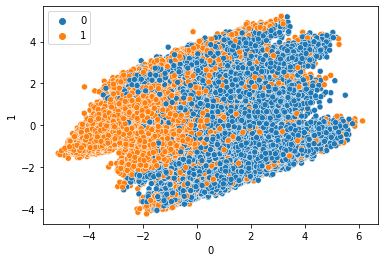

In [ ]:
sns.scatterplot(data=Xpca, x=0, y=1, hue=y)

## Primer Modelo (parametros default) con PCA

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(Xpca,y, random_state=12)
rf= RandomForestClassifier(random_state=12)
rf.fit(X_train, y_train)
y_pred=rf.predict(X_test)

**Graficamos comportamiento**

<Axes: xlabel='0', ylabel='1'>

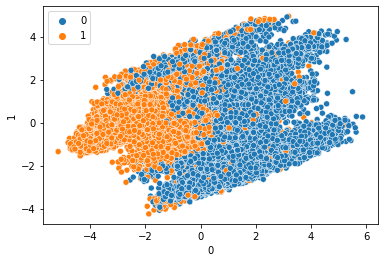

In [ ]:
sns.scatterplot(data=X_test, x=0, y=1, hue=y_pred) 

**Metricas**

In [ ]:
acurracy=metrics.accuracy_score(y_test,y_pred)
precision=metrics.precision_score(y_test,y_pred)
sensibilidad=metrics.recall_score(y_test,y_pred)
f1_score=metrics.f1_score(y_test,y_pred)

print('Exactitud:', acurracy)
print('Precision-recall:', precision)
print('Sensibilidad:',sensibilidad)
print('F1_score:',f1_score)

Exactitud: 0.917885740683708
Precision-recall: 0.9239262655562833
Sensibilidad: 0.8820796855458282
F1_score: 0.9025181664457748


**Varianza y sesgo**

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
# calcular la varianza y el sesgo mediante la validación cruzada
scores = cross_val_score(rf, Xpca, y, cv=5)
variance = scores.var()
bias = (1 - scores.mean())**2
print("Varianza:", variance)
print("Sesgo:", bias)

Varianza: 4.38460306379231e-06
Sesgo: 0.006621590054033548


## Segundo Modelo con PCA

**Aplicamos modelo #2 n_estimators=100, max_depth=10**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf= RandomForestClassifier(n_estimators=100, max_depth=10, random_state=12)
rf.fit(X_train, y_train)
y_pred=rf.predict(X_test)

**Graficamos comportamiento luego de aplicar 2do modelo**

<Axes: xlabel='0', ylabel='1'>

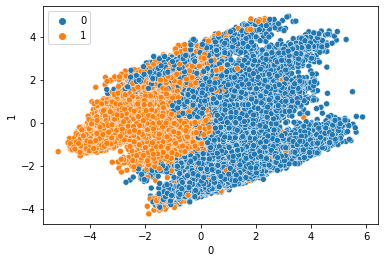

In [ ]:
sns.scatterplot(data=X_test, x=0, y=1, hue=y_pred) 

**Metricas**

In [ ]:
acurracy=metrics.accuracy_score(y_test,y_pred)
precision=metrics.precision_score(y_test,y_pred)
sensibilidad=metrics.recall_score(y_test,y_pred)
f1_score=metrics.f1_score(y_test,y_pred)

print('Exactitud:', acurracy)
print('Precision-recall:', precision)
print('Sensibilidad:',sensibilidad)
print('F1_score:',f1_score)

Exactitud: 0.900408068986757
Precision-recall: 0.9212922173274596
Sensibilidad: 0.8407182419153117
F1_score: 0.8791629688448782


**Varianza y sesgo**

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
# calcular la varianza y el sesgo mediante la validación cruzada
scores = cross_val_score(rf, Xpca, y, cv=5)
variance = scores.var()
bias = (1 - scores.mean())**2
print("Varianza:", variance)
print("Sesgo:", bias)

Varianza: 8.465653502724182e-06
Sesgo: 0.009475037378434316


## Tercer Modelo con PCA

**Aplicamos modelo #3 n_estimators=50, max_depth=5**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(Xpca,y, random_state=12)
rf= RandomForestClassifier(n_estimators=50, max_depth=5, random_state=12)
rf.fit(X_train, y_train)
y_pred=rf.predict(X_test)

**Graficamos comportamiento luego de aplicar 3er modelo**

<Axes: xlabel='0', ylabel='1'>

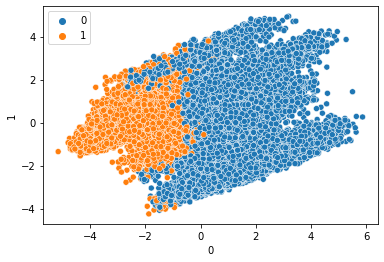

In [ ]:
sns.scatterplot(data=X_test, x=0, y=1, hue=y_pred) 

**Varianza y sesgo**

**Metricas**

In [ ]:
acurracy=metrics.accuracy_score(y_test,y_pred)
precision=metrics.precision_score(y_test,y_pred)
sensibilidad=metrics.recall_score(y_test,y_pred)
f1_score=metrics.f1_score(y_test,y_pred)

print('Exactitud:', acurracy)
print('Precision-recall:', precision)
print('Sensibilidad:',sensibilidad)
print('F1_score:',f1_score)

Exactitud: 0.8681090237141977
Precision-recall: 0.9195290559516094
Sensibilidad: 0.7604966946578524
F1_score: 0.832485820457657


**Varianza y sesgo**

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
# calcular la varianza y el sesgo mediante la validación cruzada
scores = cross_val_score(rf, Xpca, y, cv=5)
variance = scores.var()
bias = (1 - scores.mean())**2
print("Varianza:", variance)
print("Sesgo:", bias)

Varianza: 1.4488414333937256e-05
Sesgo: 0.017344475589673496


# Conclusiones
Aunque la aplicacion del PCA mantenga las variables insesgadas si vemos que hay un aumento de la varianza alias la dispersion de los datos cuando aplicamos el modelo sin PCA a cuando aplicamos los distintos modelos con PCA. Tambien existe un deterioro de las variables de aplicabilidad que tienen los modelos a los datos pre PCA y post PCA. Por lo cual en este caso en particular no recomendariamos la aplicacion de PCA para este modelo en particular.
